# Predict rain based on other weather variables

This notebook will use time lags to train a machine learning model for predicting wind speed. 

First, we select a random station. The data is kept at daily resolution. Then, we generate a lagged feature matrix.

In [190]:
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import glob
from mpl_toolkits.basemap import Basemap

In [ ]:
data_dir = '/datasets/NOAA_SST/'
#load(data_dir + “noaa_gsod/…/file”
t0 = time.time()
data = pd.read_pickle(data_dir+'noaa_gsod/Combined_noaa_gsod') # load weather data
stations = pd.read_pickle(data_dir+'noaa_gsod.stations') # load station data

# # USE ONLY 2008-2018 # #
data = data.loc[data.index >= pd.Timestamp(2008, 1, 1)]
data = data.drop(columns=['yr','year','da','mo']) # don't need these anymore
print(time.time()-t0)

In [10]:
stations.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
0,007018,99999,WXPOD 7018,None,None,None,0.00,0.000,+7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,None,None,0.00,0.000,+7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,None,None,0.00,0.000,+7070.0,20140923,20150926
3,008268,99999,WXPOD8278,AF,None,None,32.95,65.567,+1156.7,20100519,20120323
4,008307,99999,WXPOD 8318,AF,None,None,0.00,0.000,+8318.0,20100421,20100421


In [11]:
data.head()

,stn,temp,slp,wdsp,mxpsd,max,min,prcp
Datetime,,,,,,,,
2008-08-22,619970,41.7,1032.1,7.2,14.0,46.6,37.8,0.00
2008-09-28,714170,54.9,1023.8,9.1,15.0,70.3,51.4,0.06
2008-02-14,041560,35.6,1032.8,28.5,38.9,36.5,34.5,0.00
2008-02-25,041560,4.5,997.1,4.3,7.0,10.4,-1.1,0.00
2008-10-06,041650,43.3,998.8,24.3,30.9,44.6,40.3,0.00


In [16]:
%%time
# # SELECT RANDOM STATION # #
# np.random.seed(6)
rs = np.unique(data['stn'].values) # find unique stations with data
# rand_stat = rs[randint(len(rs))] # pick a random station
rand_stat = '294180'

# # # ideally we should check < len(np.unique(data.index)), but many are shorter
# while (len(data.loc[data['stn'] == rand_stat]) < 3650): # If not enough data
#     if len(stations.loc[stations['usaf'] == rand_stat]): # If station info available
#         if (stations.loc[stations['usaf'] == rand_stat].iloc[0]['wban'] != '99999'): # If station number not unique
#             rand_stat = rs[randint(len(rs))] # get a new station
#     else:
#         rand_stat = rs[randint(len(rs))] # get a new station

select_station = stations.loc[stations['usaf'] == rand_stat] # get location, etc, for random station



CPU times: user 38.3 s, sys: 1.19 s, total: 39.5 s
Wall time: 39.1 s


In [171]:
features = data.loc[data['stn'] == rand_stat] # pick weather at random station
features = features.drop(columns='stn')
features = features.sort_index()
select_station.head() # see where it is

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
20891,294180,99999,SEVERNOE,RS,None,None,56.35,78.35,+0126.0,19480101,20190401


In [172]:
features.head()

,temp,slp,wdsp,mxpsd,max,min,prcp
Datetime,,,,,,,
2008-01-01,14.0,1027.7,6.1,7.8,15.4,12.2,0.08
2008-01-02,3.9,1026.0,6.6,9.7,14.7,-15.5,0.08
2008-01-03,-25.4,1037.0,2.9,9.7,-20.2,-34.6,0.00
2008-01-04,-25.4,1041.0,2.4,5.8,-15.7,-38.4,0.00
2008-01-05,-0.5,1029.8,7.0,11.7,11.3,-24.7,0.08


In [174]:
import scipy.signal as sig

### Time-shift the data

In [175]:
# features = features_means.drop(columns='mxpsd') # Drop maximum wind speed that day
columns = features.columns # weather variables

for co in columns:
    # one day lag
    features[co + '_lag1'] = features[co].shift(periods=1)
    
    # two days lag
    features[co + '_lag2'] = features[co].shift(periods=2)
    
    # three days lag
    features[co + '_lag3'] = features[co].shift(periods=3)
features = features.iloc[3:]
print(str(len(features)) + ' samples, ' + str(len(features.columns)) + ' features.')
features.head()

3858 samples, 28 features.


,temp,slp,wdsp,mxpsd,max,min,prcp,temp_lag1,temp_lag2,temp_lag3,...,mxpsd_lag3,max_lag1,max_lag2,max_lag3,min_lag1,min_lag2,min_lag3,prcp_lag1,prcp_lag2,prcp_lag3
Datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-04,-25.4,1041.0,2.4,5.8,-15.7,-38.4,0.00,-25.4,3.9,14.0,...,7.8,-20.2,14.7,15.4,-34.6,-15.5,12.2,0.00,0.08,0.08
2008-01-05,-0.5,1029.8,7.0,11.7,11.3,-24.7,0.08,-25.4,-25.4,3.9,...,9.7,-15.7,-20.2,14.7,-38.4,-34.6,-15.5,0.00,0.00,0.08
2008-01-06,9.5,1030.9,2.9,5.8,13.8,-5.8,0.03,-0.5,-25.4,-25.4,...,9.7,11.3,-15.7,-20.2,-24.7,-38.4,-34.6,0.08,0.00,0.00
2008-01-07,6.1,1034.7,2.9,3.9,12.9,-6.0,0.00,9.5,-0.5,-25.4,...,5.8,13.8,11.3,-15.7,-5.8,-24.7,-38.4,0.03,0.08,0.00
2008-01-08,14.1,1031.3,4.6,5.8,17.6,7.0,0.00,6.1,9.5,-0.5,...,11.7,12.9,13.8,11.3,-6.0,-5.8,-24.7,0.00,0.03,0.08


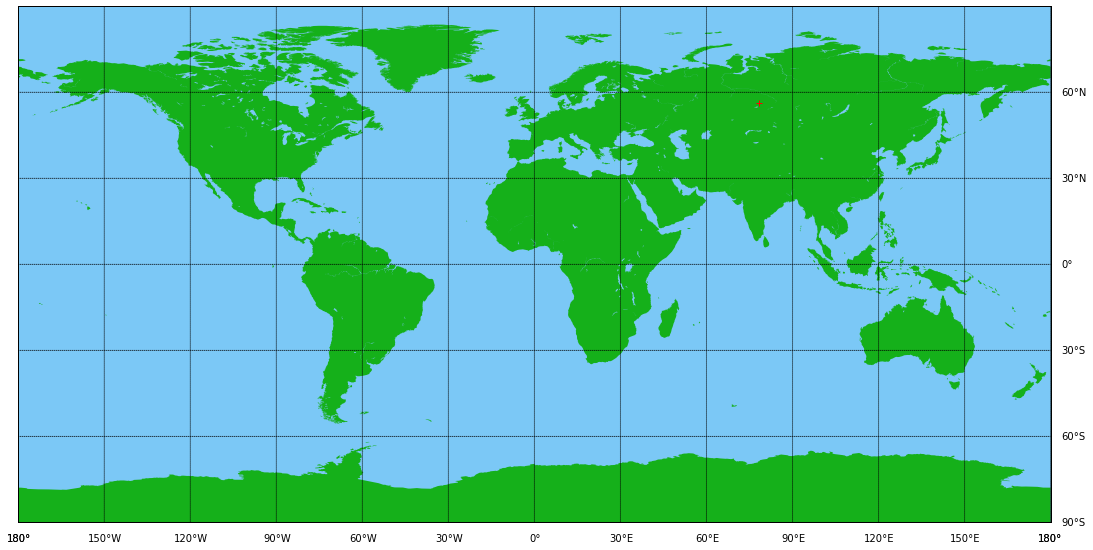

In [176]:
# View station locations
fig = plt.figure(figsize=(18.5, 10.5))
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180, resolution='l')
m.drawmapboundary(fill_color='xkcd:lightblue')
m.fillcontinents(color='xkcd:green',lake_color='xkcd:lightblue')
m.drawmeridians(np.arange(-180.,180.,30.),labels=[True,False,False,True])
m.drawparallels(np.arange(-90.,90,30.),labels=[False,True,True,False])
lon = select_station['lon'].tolist()
lat = select_station['lat'].tolist()
#xpt,ypt = m(lon,lat)
m.plot(lon, lat,'r+') 
#m.plot(179.75, -19.133, 'ro')
plt.show()

### Create train/val/test

In [177]:
ylabel = features['wdsp'] # use today's wind speed as the label
features = features.drop(columns='wdsp') # don't put it in training data!!
features = features.drop(columns='max')
features = features.drop(columns='prcp')

# Use 20% test split (80% training + validation)
ntrain = int(len(features)*0.8)
x_test = features.iloc[ntrain:,:]
y_test = ylabel[ntrain:]
indices = np.arange(ntrain)

# Split remaining 80% into training-validation sets (of original data)
x_train, x_val, y_train, y_val = train_test_split(features.iloc[0:ntrain,:], ylabel[0:ntrain],
                                                  test_size=0.2, random_state=1)

# Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

### Predict with Random Forest

In [186]:
# # Create, train, and predict random forest here # #
regr = RandomForestRegressor(n_estimators=150,max_features = 5) 
regr.fit(x_train, y_train) 
y = regr.predict(x_test)
score = regr.score(x_test, y_test)
print(score)
val_prd = regr.predict(x_val)
tra_prd = regr.predict(x_train)

tra_set = scaler.transform(features.iloc[0:ntrain,:])
tra = regr.predict(tra_set)

0.8237818654097047


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
model = ARIMA(train, order=(1, 1, 1)) 


In [130]:
from sklearn.metrics import mean_squared_error as MSE

In [187]:
print(MSE(y_train,tra_prd))
print(MSE(y_val,val_prd))
print(MSE(y_test,y))


0.23059463857374304
1.5877169003955411
1.3182178624064484


### Plot the random forest

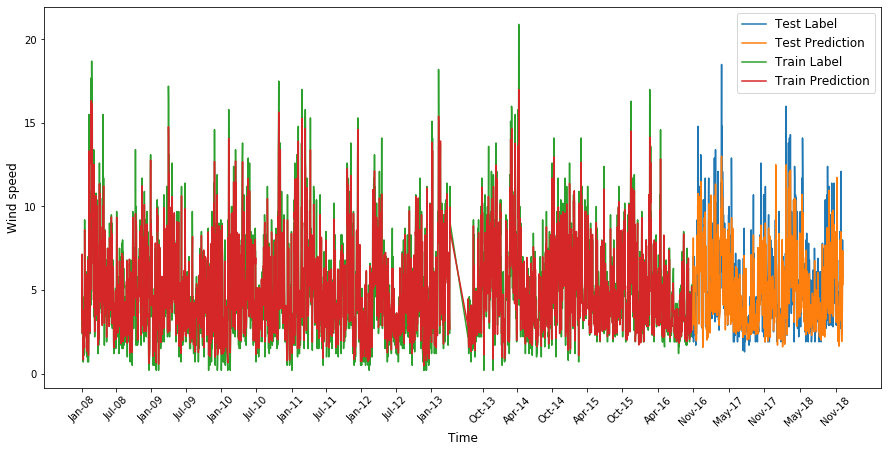

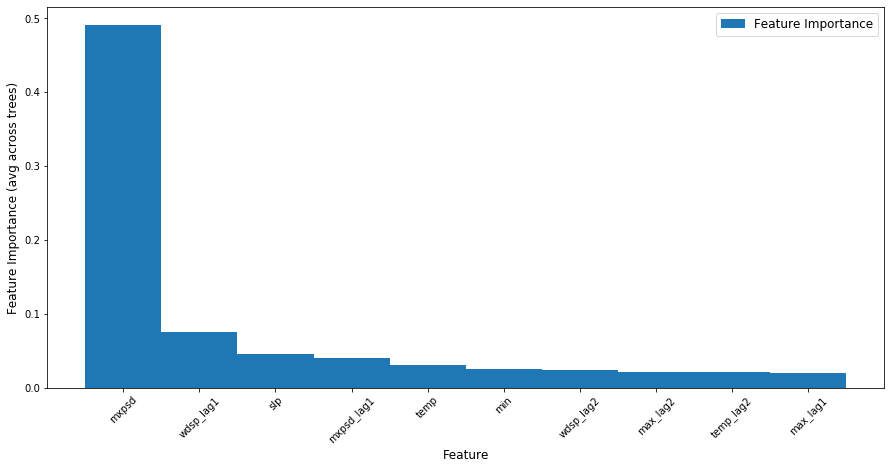

In [188]:
# plot predictions
plt.figure(figsize=(15,7))
# plt.subplot(1,2,1)
plt.plot(features.iloc[ntrain:].index,y_test) # plot actual temperature
plt.plot(features.iloc[ntrain:].index, y) # plot predicted temperature

# # PLOT THE PREDICTED TRAINING AND VALIDATION DATA HERE # #
plt.plot(features.iloc[:ntrain].index,ylabel[0:ntrain])


plt.plot(features.iloc[:ntrain].index,tra)


# # INCREASE X TICK SPACING, UPDATE LEGEND # #
plt.xticks(features.iloc[:].index[::182], rotation = 45) # set xticks to monthly
myFmt = mdates.DateFormatter('%b-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Wind speed', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(['Test Label','Test Prediction','Train Label','Train Prediction'], fontsize=12, loc=1)
plt.show()

# # Plot the feature importances # #
plt.figure(figsize=(15,7))
nfeatures = 10
fi = regr.feature_importances_ # get feature importances
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
# plt.subplot(1,2,2)
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[fi_sort[0:nfeatures]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.xticks(rotation = 45)
plt.legend(['Feature Importance'], fontsize=12, loc=1)
plt.show()

### Feature importance is the weighted impurity of a branch adjusted by its children nodes and normalized by the impurities of all branches. The Random Forest feature importances are averaged over all regression trees.